In [1]:
import cv2
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import torch
from ultralytics import YOLO
from shapely.geometry import Polygon
from torchvision.ops import masks_to_boxes

In [2]:
array_img = np.asarray(img)
contours, _ = cv2.findContours(array_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# polygons = []
# normalized_polygons = []
# for contour in contours:
#     try: 
#         polygon = contour.reshape(-1, 2).tolist()
#         # normalized_polygon = [[round(coord[0] / mask.shape[1] , 4), round(coord[1] / mask.shape[0] , 4)] for coord in polygon]
#         polygon_shapely = Polygon(polygon)
#         simplified_polygon = polygon_shapely  #.simplify(0.8, preserve_topology=True)
#         simplified_polygon_norm = [[round(coord[0] / array_img.shape[1] , 4), round(coord[1] / array_img.shape[0] , 4)] for coord in simplified_polygon.exterior.coords]
#         polygons.append(simplified_polygon)
#         normalized_polygons.append(Polygon(simplified_polygon_norm))
#     except Exception as e:
#         pass

NameError: name 'img' is not defined

In [128]:
im = Image.new('L', (640 * 2, 480 * 2), 0)
draw = ImageDraw.Draw(im)

points_str = '0'
for poly in normalized_polygons:
    for point in poly.exterior.coords:
        x, y = point
        points_str += f' {x} {y}'
        draw.ellipse((x * im.size[0] - 1, y * im.size[1] - 1 ,  x * im.size[0] + 1,  y * im.size[1] + 1), fill=255)
    break  

In [2]:
from typing import List, Tuple


def get_bbox_from_mask(img: Image.Image) -> List[Tuple[float, ...]]:
    contours, _ = cv2.findContours(np.asarray(img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_wh = img.size
    all_bboxes = []
    shapes = []
    for i in range(len(contours)):
        shapes.append(contours[i].shape[1])
        mined = contours[i][:, 0, :].min(0)
        maxed = contours[i][:, 0, :].max(0)
        bbox_coords = (mined[0], mined[1], maxed[0], maxed[1])
        if bbox_coords[2] - bbox_coords[0] < 2 or bbox_coords[3] - bbox_coords[1] < 2:
            continue
        shape_norm = (
            (bbox_coords[2] + bbox_coords[0]) / (2 * img_wh[0]),
            (bbox_coords[3] + bbox_coords[1]) / (2 * img_wh[1]),
            (bbox_coords[2] - bbox_coords[0]) / img_wh[0],
            (bbox_coords[3] - bbox_coords[1]) / img_wh[1],
        )
        all_bboxes.append(shape_norm)
    return all_bboxes

def xywh_xyxy(box, img_size):
    return ((box[0] - box[2] / 2) * img_size[0], (box[1] - box[3] / 2) * img_size[1], (box[0] + box[2] / 2) * img_size[0], (box[1] + box[3] / 2) * img_size[1])

def form_yolo_txt(bboxes, mask_path: Path, new_root: Path):
    txt_path = new_root / f'{(mask_path.stem.replace("_mask", "_original"))}.txt'
    final_string = ''
    for bbox in bboxes:
        x, y, w, h = bbox
        final_string += f'0 {x} {y} {w} {h}\n'

    txt_path.write_text(final_string)

In [3]:
def process_bub_masks_to_yolo(masks_dir: Path, zones_dir: Path):
    new_root_txt = masks_dir.parent / 'txt_masks_crop'
    new_root_crops = masks_dir.parent / 'orig_crop'

    new_root_txt.mkdir(exist_ok=True)
    new_root_crops.mkdir(exist_ok=True)

    for mask_path in masks_dir.glob('*.png'):
        img = Image.open(mask_path).convert('L')
        orig = Image.open(masks_dir.parent / 'original' / mask_path.name.replace('_mask', '_original'))
        zone = np.asarray(Image.open(zones_dir / mask_path.name))[..., 2] > 0
        zone_bbox = masks_to_boxes(torch.tensor(zone).unsqueeze(0))[0]
        zone_bbox[:2] -= 32
        zone_bbox[2:] += 32
        cropped = img.crop(zone_bbox.numpy())
        cropped.save(new_root_crops / mask_path.name)
        orig_crop = orig.crop(zone_bbox.numpy())
        orig_crop.save(new_root_crops / mask_path.name.replace('_mask', '_original'))
        bboxes = get_bbox_from_mask(cropped)
        form_yolo_txt(bboxes, mask_path, new_root_txt)

In [4]:
process_bub_masks_to_yolo(Path('/home/nekrut/dataset/water_processing/seg_fs/mask/'), Path('/home/nekrut/dataset/water_processing/seg_fs/zones_mask/'))

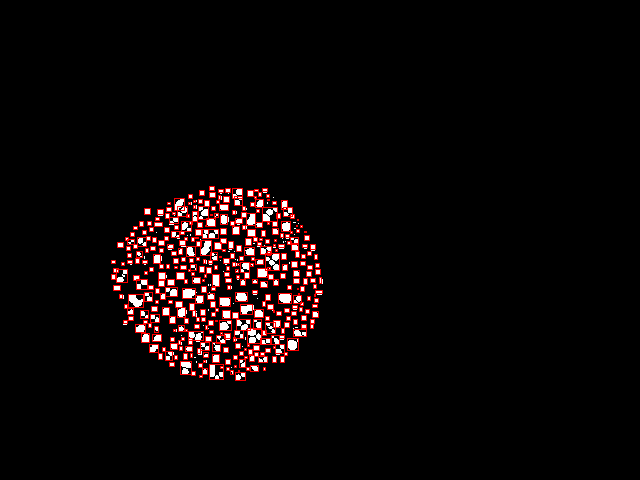

In [24]:
img_n = img.copy()

# create  rectangleimage 
img1 = ImageDraw.Draw(img_n)
img_size = img.size
for box in bboxes:
    bbox_coords = xywh_xyxy(box, img_size)
    
    img1.rectangle(bbox_coords, outline ="red")
img_n

In [53]:
model = YOLO('yolov8n.yaml');


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [55]:
model.train(
    data='/home/nekrut/dataset/water_processing/seg_fs/yolo/wdp-yolo-bubs.yaml',
    optimizer='SGD',
    epochs=1000,
    imgsz=512,
    batch=3,
    patience=500,
    save_period=1000,
    single_cls=True,
    cos_lr=True,
    lr0=1e-4,
    lrf=1e-3,
    weight_decay=5e-5,
    warmup_epochs=10,
    amp=False,
    degrees=0,
    translate=0,
    scale=0,
    shear=0,
    perspective=0,
    flipud=0,
    fliplr=0,
    mosaic=0,
    mixup=0,
    copy_paste=0,
    hsv_s=0,
    hsv_v=0,
    # mask_ratio=1,
    # overlap_mask=True,
    cache='ram',
    resume=False,
    pretrained=True,
    project='wdp_yolo_bubs',
    name='v1',
)

New https://pypi.org/project/ultralytics/8.0.208 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.163 🚀 Python-3.9.17 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/nekrut/dataset/water_processing/seg_fs/yolo/wdp-yolo-bubs.yaml, epochs=1000, patience=500, batch=3, imgsz=512, save=True, save_period=1000, cache=ram, device=None, workers=8, project=wdp_yolo_bubs, name=v1, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=No